## Automated Legal Document Summarization

## Scope: Legal documents in PDF format of various categories. Master Clauses csv with human extracted answers under different catergories for these documents.
## Deliverable: Given an input query, when processed by the RAG pipeline, will get relevant information.
## Evaluation: Similarity of RAG pipeline result with the human responses in the master clauses.

### Import libraries

In [5]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
## installed pdf2image and pytsseract << !pip install pdf2image pytesseract
## installed poppler <<brew install poppler>>
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pytesseract
from pdf2image import convert_from_path
import pandas as pd
import os

# Directory containing multiple PDF files
pdf_directory = '/Users/vaibhavsrivastava/Bits AIML/Capstone/Submissions/Work folder/'

# Initialize an empty list to hold data for all contracts
all_contracts_data = []

## We will be using paragraph level granularity

In [10]:
# Loop through each PDF file in the directory
for pdf_file in os.listdir(pdf_directory):
    if pdf_file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_directory, pdf_file)  # Get full path of the PDF file
        
        # Convert PDF to a list of images (one per page)
        pages = convert_from_path(pdf_path, 300)  # 300 DPI for good OCR quality
        
        # Loop through each page, perform OCR, and split by paragraphs
        for i, page in enumerate(pages):
            # Perform OCR on the image
            text = pytesseract.image_to_string(page, lang='eng')
            
            # Split text into paragraphs (assuming paragraphs are separated by double newlines)
            paragraphs = text.split('\n\n')  # Splitting by two newlines
            
            # Append each paragraph as a new row in the data
            for paragraph in paragraphs:
                if paragraph.strip():  # Only append non-empty paragraphs
                    all_contracts_data.append({
                        'contract_name': pdf_file,  # Contract name (file name)
                        'page_number': i + 1,       # Page number
                        'text': text,               # Extracted text
                        'paragraph': paragraph      # Extracted paragraph text
                    })

# Convert the list of all contracts data to a DataFrame
df_all_contracts = pd.DataFrame(all_contracts_data)

# Display the DataFrame
print(df_all_contracts)

# Optionally, save the DataFrame to a CSV file for later use
df_all_contracts.to_csv('contracts_paragraphs_data.csv', index=False)

                                          contract_name  page_number  \
0     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
1     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
2     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
3     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
4     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
...                                                 ...          ...   
5833  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   
5834  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   
5835  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   
5836  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   
5837  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   

                                                   text  \
0     Exhibit 10.54\nDISTRIBUTION AND DEVELOPMENT AG...   
1     Exhibit 10.

## we now have all the contracts as a single dataframe, each row corresponding to one paragraph of each page of a contract. There are four cols contract-name, page_number, text and paragraph.

## Text Preprocessing

In [13]:
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function for preprocessing
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join tokens back into a string
    return ' '.join(tokens)

# Remove rows with NaN in the 'paragraph' column before processing
df_cleaned = df_all_contracts.dropna(subset=['paragraph'])

# Remove rows where 'paragraph' has less than 20 characters (excluding empty rows)
df_cleaned = df_cleaned[df_cleaned['paragraph'].str.len() >= 20]

# Remove rows where 'paragraph' contains the word "Source:" This will remove the footer
df_cleaned = df_cleaned[~df_cleaned['paragraph'].str.contains("Source:", case=False, na=False)]

# Apply the text preprocessing function to the cleaned DataFrame
df_cleaned['processed_para'] = df_cleaned['paragraph'].apply(preprocess_text)

# Drop the 'text' and 'paragraph' column
df_processed_para = df_cleaned.drop(columns=['text', 'paragraph'])

# Display the processed DataFrame
print(df_processed_para)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vaibhavsrivastava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vaibhavsrivastava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vaibhavsrivastava/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                          contract_name  page_number  \
0     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
1     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
2     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
3     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
4     RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
...                                                 ...          ...   
5831  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   
5832  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   
5833  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   
5834  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   
5836  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...            1   

                                         processed_para  
0       exhibit 1054 distribution development agreement  
1     distribution 

### Visualization

### Word clouds are great for visualizing the most frequent words across the dataset. Below cloud depicts word frequency across all contracts being processed

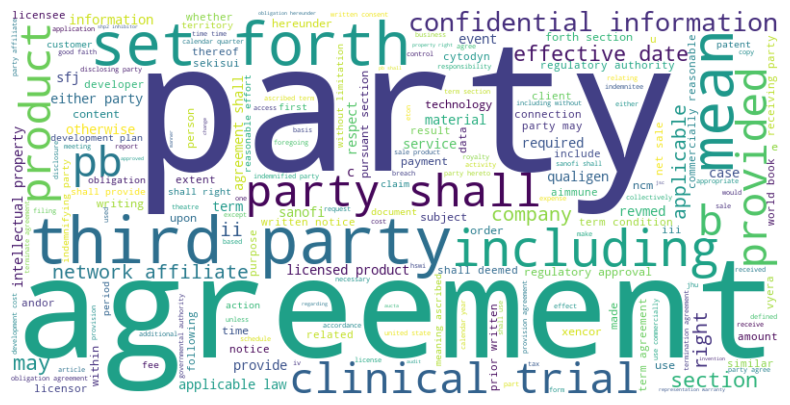

In [16]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text from the 'processed_text' column into a single string
all_text = ' '.join(df_processed_para['processed_para'].dropna())

# Customizing the word cloud
wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white',
                      colormap='viridis', stopwords=stop_words).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Using clustering to group similar paragraphs based on their content. This can reveal different themes or topics within contract dataset.
For text clustering, we’ll use TF-IDF to represent the paragraphs and then use KMeans for clustering.

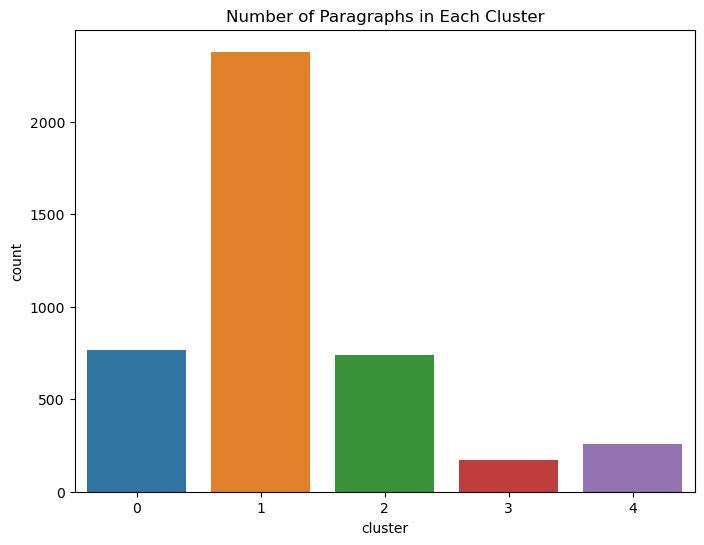

                                       contract_name  page_number  \
0  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
1  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
2  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
3  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   
4  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            1   

                                      processed_para  cluster  
0    exhibit 1054 distribution development agreement        1  
1  distribution development agreement “ agreement...        1  
2  whereas qualigen engaged manufacture supply de...        1  
3  whereas qualigen wish appoint sekisui exclusiv...        2  
4  whereas sekisui wish appointed exclusive distr...        2  


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Convert processed paragraphs into TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df_processed_para['processed_para'])

# Perform KMeans clustering
num_clusters = 5  # total nbr of contracts
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_processed_para['cluster'] = kmeans.fit_predict(X_tfidf)

# Visualize the number of paragraphs in each cluster
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=df_processed_para)
plt.title('Number of Paragraphs in Each Cluster')
plt.show()

# Display the first few rows with their cluster assignment
print(df_processed_para[['contract_name', 'page_number', 'processed_para', 'cluster']].head())

### Combining Clustering and Word Cloud for Each Cluster:
Generating a word cloud for each cluster to understand the most frequent words in each group of similar paragraphs.

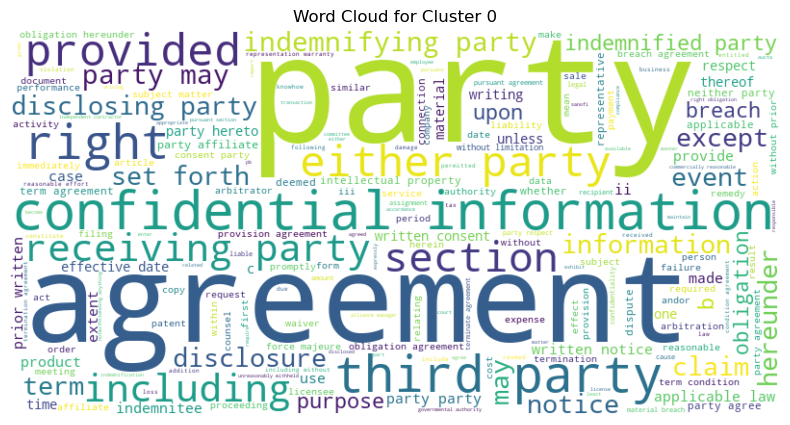

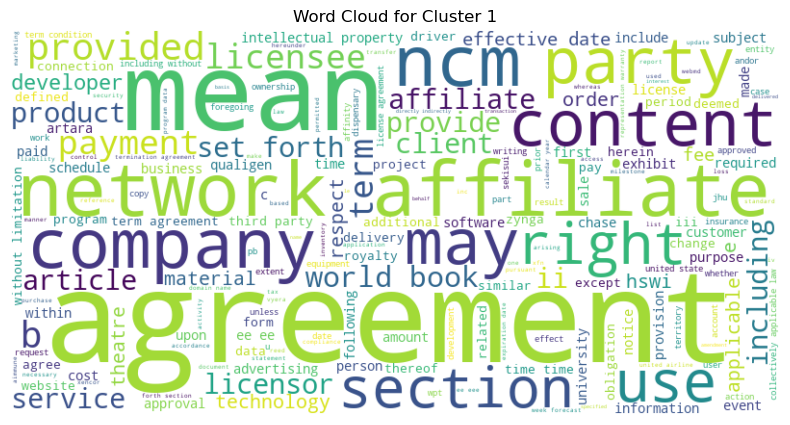

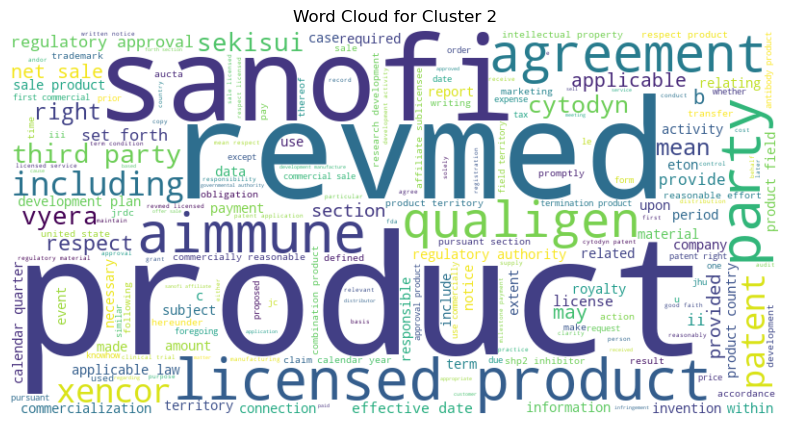

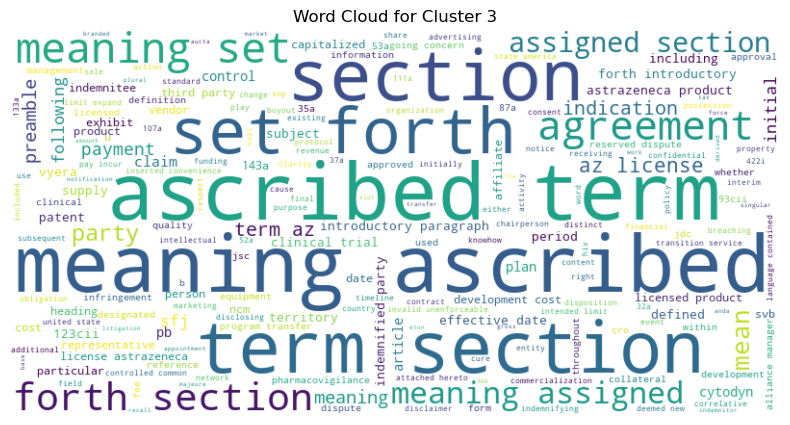

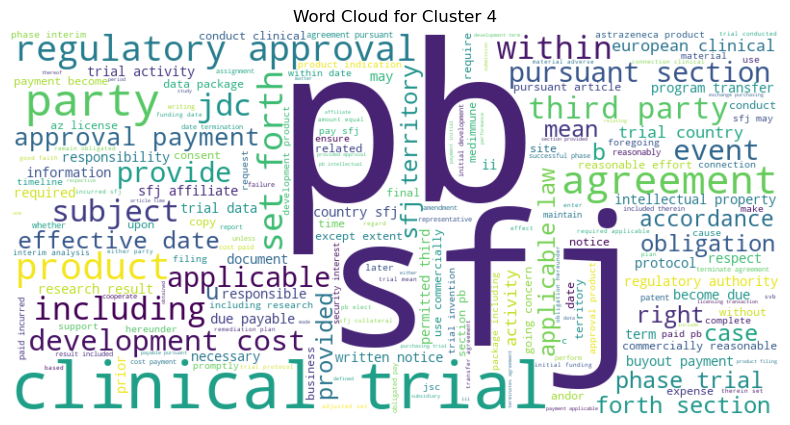

In [20]:
# Generate word clouds for each cluster
for cluster in range(num_clusters):
    cluster_text = ' '.join(df_processed_para[df_processed_para['cluster'] == cluster]['processed_para'])
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cluster_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.title(f'Word Cloud for Cluster {cluster}')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

The word cloud clusters are reflecting more frequent words in each cluster where TF-IDF helps to represent the paragraphs

### visualize the clusters in 2D space, using t-SNE to reduce the dimensionality of the TF-IDF vectors and then plot the clusters.

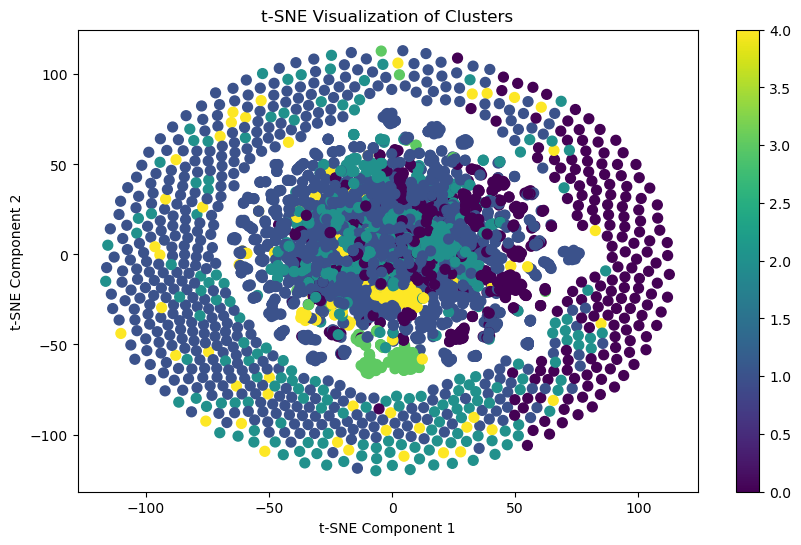

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df_processed_para['cluster'], cmap='viridis', s=50)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

## Following a hybrid approach:

a. Cluster paragraphs first to group similar content.

b. Apply LDA within each cluster to further refine the topics or themes within these groups.

This will give the best of both worlds—clear groupings based on content, with detailed topic insights within each group.

In [25]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel
from nltk.corpus import stopwords
from gensim.corpora import Dictionary

In [26]:
print(df_processed_para.columns)

Index(['contract_name', 'page_number', 'processed_para', 'cluster'], dtype='object')


In [27]:
# Store topic assignments and cluster-specific LDA models/dictionaries
topic_assignments = []
lda_models = {}   # Store LDA models by cluster
dictionaries = {} # Store dictionaries by cluster

for cluster_num, cluster_data in df_processed_para.groupby('cluster'):
    # Tokenize and preprocess for LDA
    tokenized_data = [word_tokenize(doc.lower()) for doc in cluster_data['processed_para']]
    tokenized_data = [[word for word in doc if word.isalpha() and word not in stop_words] for doc in tokenized_data]
    
    # Create Dictionary and Corpus for LDA
    dictionary = Dictionary(tokenized_data)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_data]
    
    # Train LDA model on the cluster data
    lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

    # Store the LDA model and dictionary for this cluster
    lda_models[cluster_num] = lda_model
    dictionaries[cluster_num] = dictionary
    
    # Iterate over both corpus and cluster_data rows
    for doc_bow, (_, row) in zip(corpus, cluster_data.iterrows()):
        topic_probs = lda_model[doc_bow]
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        topic_assignments.append((row['contract_name'], row['page_number'], row['processed_para'], cluster_num, dominant_topic))

# Convert the results to a DataFrame
df_topics = pd.DataFrame(topic_assignments, columns=['contract_name', 'page_number', 'processed_para', 'cluster', 'dominant_topic'])

# Display the resulting DataFrame
print(df_topics.head())

                                       contract_name  page_number  \
0  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            3   
1  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            3   
2  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...            5   
3  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...           10   
4  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...           11   

                                      processed_para  cluster  dominant_topic  
0  126 third party shall mean party sekisui quali...        0               1  
1  22 term initial term agreement shall commence ...        0               3  
2  33 order order shall processed set forth exhib...        0               1  
3  61 management committee party shall within fiv...        0               4  
4  62 meeting management committee shall responsi...        0               4  


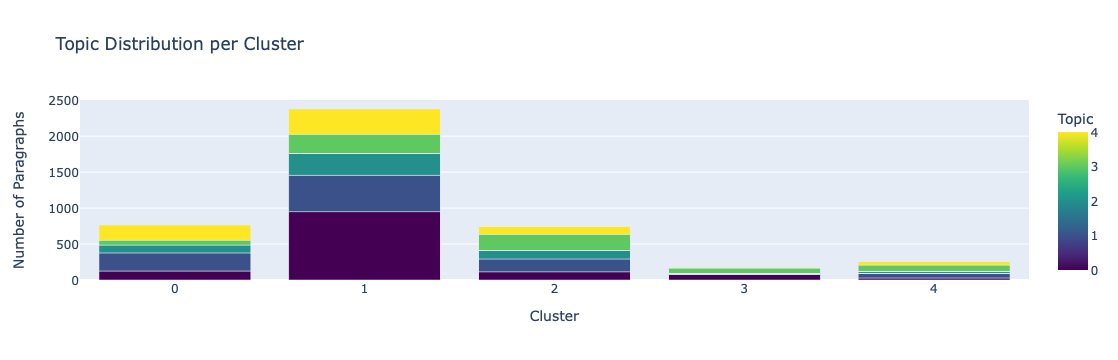

In [28]:
import plotly.express as px

# Count topics within each cluster
topic_counts = df_topics.groupby(['cluster', 'dominant_topic']).size().reset_index(name='count')

# Create an interactive bar plot
fig = px.bar(topic_counts, 
             x='cluster', 
             y='count', 
             color='dominant_topic',
             barmode='stack',
             title='Topic Distribution per Cluster',
             labels={'count': 'Number of Paragraphs', 'dominant_topic': 'Topic'},
             color_continuous_scale=px.colors.sequential.Viridis)

fig.update_layout(xaxis_title='Cluster', yaxis_title='Number of Paragraphs')
fig.show()


In [29]:
#Explore the Key Words Defining Each Topic
# Print the topics with top words
topics = lda_model.show_topics(formatted=False)
for topic_id, words in topics:
    print(f"Topic {topic_id}: {[word for word, prob in words]}")

Topic 0: ['clinical', 'trial', 'product', 'applicable', 'phase', 'amended', 'mean', 'country', 'sfj', 'pb']
Topic 1: ['pb', 'sfj', 'payment', 'shall', 'section', 'approval', 'agreement', 'pursuant', 'amount', 'cost']
Topic 2: ['pb', 'sfj', 'phase', 'product', 'trial', 'filing', 'regulatory', 'applicable', 'shall', 'country']
Topic 3: ['trial', 'clinical', 'pb', 'sfj', 'party', 'product', 'regulatory', 'development', 'approval', 'phase']
Topic 4: ['sfj', 'pb', 'party', 'trial', 'clinical', 'jdc', 'shall', 'territory', 'activity', 'protocol']


## Summary DataFrame that lists the cluster number, the associated topics, and a sample paragraph for each cluster

In [31]:
import pandas as pd
from collections import defaultdict

# Define a function to extract top words from LDA model
def get_top_words(model, num_words=5):
    # Get the words for each topic
    top_words = {}
    for topic_id, topic in model.show_topics(formatted=False, num_words=num_words):
        top_words[topic_id] = [word for word, _ in topic]
    return top_words

# Get top words from the LDA model
top_words = get_top_words(lda_model)

# Prepare a list to store summaries
summary_list = []

# Sample paragraphs from the DataFrame
for cluster in df_topics['cluster'].unique():
    cluster_data = df_topics[df_topics['cluster'] == cluster]
    
    for topic in cluster_data['dominant_topic'].unique():
        topic_data = cluster_data[cluster_data['dominant_topic'] == topic]
        
        # Get two sample paragraphs, ensuring we don't sample more than available
        sample_paragraphs = topic_data['processed_para'].sample(n=min(2, len(topic_data)), random_state=1).tolist()
        
        # Append to summary list
        summary_list.append({
            'Cluster': cluster,
            'Topic': topic,
            'Top Words': top_words.get(topic, []),  # Safely get the top words
            'Sample Paragraphs': sample_paragraphs
        })

# Convert the summary list to a DataFrame for better readability
summary_df = pd.DataFrame(summary_list)

# Convert the top words list to a string for better display
summary_df['Top Words'] = summary_df['Top Words'].apply(lambda x: ', '.join(x))

# Join sample paragraphs for display
summary_df['Sample Paragraphs'] = summary_df['Sample Paragraphs'].apply(lambda x: ' | '.join(x))

# Display the summary DataFrame
print(summary_df)


    Cluster  Topic                                    Top Words  \
0         0      1             pb, sfj, payment, shall, section   
1         0      3              trial, clinical, pb, sfj, party   
2         0      4              sfj, pb, party, trial, clinical   
3         0      0  clinical, trial, product, applicable, phase   
4         0      2               pb, sfj, phase, product, trial   
5         1      0  clinical, trial, product, applicable, phase   
6         1      2               pb, sfj, phase, product, trial   
7         1      4              sfj, pb, party, trial, clinical   
8         1      3              trial, clinical, pb, sfj, party   
9         1      1             pb, sfj, payment, shall, section   
10        2      3              trial, clinical, pb, sfj, party   
11        2      2               pb, sfj, phase, product, trial   
12        2      4              sfj, pb, party, trial, clinical   
13        2      0  clinical, trial, product, applicable, phas

In [32]:
# Visualize the Topics
import pyLDAvis.gensim
import pyLDAvis
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Prepare the pyLDAvis visualization
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis)

### Now that we have Clustering augmented by LDA-based topic similarity as a hybrid approach. Adding SentenceTransformer-based semantic similarity, one can achieve both thematic relevance and fine-grained semantic matching. This hybrid method can help retrieve the most contextually relevant paragraphs from legal documents based on the user's query.

### Create Vector Embeddings:
We can create vector embeddings using:

TF-IDF: Basic embeddings based on term frequency.

Word2Vec: Embeddings that capture word semantics.

BERT or Sentence Transformers: Contextualized embeddings (recommended for advanced tasks).

## Implementing embeddings for contract name and paragraph text using sentence transformers , model name = all-MiniLM-L6-v2

In [42]:
# Combine both contract name and processed para to create single embeddings
from sentence_transformers import SentenceTransformer, util
import numpy as np

# Initialize the model for embeddings
Sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

def find_embeddings(sentence):
  return Sentence_model.encode(sentence)

from sklearn.metrics.pairwise import cosine_similarity

#similarity score function
def embedding_similarity(lst):
  result = []
  a = lst[0]
  for i in range(1,len(lst)):
    b = lst[i]
    result.append(cosine_similarity([a], [b])[0][0])
  return result

df_topics['contract_name_embedding'] = df_topics['contract_name'].apply(find_embeddings)
df_topics['processed_para_embedding'] = df_topics['processed_para'].apply(find_embeddings)

# Convert contract name embeddings from DataFrame to numpy array
contract_name_embeddings = np.vstack(df_topics['contract_name_embedding'].to_numpy())
processed_para_embeddings = np.vstack(df_topics['processed_para_embedding'].to_numpy())

# Concatenate contract name and processed paragraph for each row
df_topics['combined_text'] = df_topics['contract_name'] + " " + df_topics['processed_para']

# Generate embeddings for the combined text
combined_embeddings = np.array(Sentence_model.encode(df_topics['combined_text'].tolist()))

# Display the shape of the resulting embeddings
print(f"Combined Embeddings Shape: {combined_embeddings.shape}")

# Add the embeddings as a new column in the DataFrame
df_topics['combined_embedding'] = combined_embeddings.tolist()

# Verify by checking the head of the DataFrame
#print(df_topics[['contract_name', 'page_number', 'combined_text', 'contract_name_embedding', 'processed_para_embedding', 'combined_embedding']].head())

Combined Embeddings Shape: (4308, 384)


## To store and manage embeddings efficiently, especially for tasks like semantic search, we need to load these embeddings into a vector database. Several specialized databases support vector storage and similarity search, including Pinecone, Weaviate, FAISS, and Milvus.

Pinecone: Managed, scalable vector database for semantic search, suitable for production.

FAISS: Local similarity search for dense vectors, faster but less scalable than cloud-based solutions.

Weaviate/Milvus: Open-source alternatives to Pinecone that support high-dimensional similarity search.

### We will be going with FAISS which is an open-source library for efficient similarity search of dense vectors. FAISS is fast and works locally, but it lacks the scalability and ease of management of cloud-based solutions like Pinecone.

In [44]:
# Define FAISS index
import faiss

# Determine the dimensionality of the embeddings (embedding_dimension)
embedding_dimension = processed_para_embeddings.shape[1]

# Initialize the FAISS index (for L2/Euclidean distance)
faiss_index = faiss.IndexFlatL2(embedding_dimension)

# Add embeddings to the FAISS index
faiss_index.add(processed_para_embeddings)  # Embeddings should be in float32 format
print(f"Number of embeddings added: {faiss_index.ntotal}")

Number of embeddings added: 4308


In [45]:
#Save the index for later use
faiss.write_index(faiss_index, "faiss_index.bin")

In [46]:
# Generate a query embedding (use the same model that created the original embeddings) to check the Vector DB loaded properly
query_text = "Find similar contracts to this text"
query_embedding = Sentence_model.encode(query_text).reshape(1, -1).astype(np.float32)

# Search the FAISS index (k=5 means top 5 results)
D, I = faiss_index.search(query_embedding, k=5)

# Print the indices of the most similar embeddings
print(f"Indices of top 5 similar contracts: {I[0]}")
print(f"Distances of top 5 similar contracts: {D[0]}")

Indices of top 5 similar contracts: [ 762 1303  142 3994 3082]
Distances of top 5 similar contracts: [1.0921429 1.1311089 1.144697  1.1679981 1.1852434]


In [47]:
#Name similarity embeddings
def find_similarity_with_question(df):
  #df['query_score_with_contract_name'] =  embedding_similarity([query_embedding,df['contract_name_embedding']])[0]
  similarities = util.cos_sim(query_embedding, contract_name_embeddings)

  # Add similarity scores to DataFrame
  df['query_score_with_contract_name'] = similarities[0]
  return df

def calculate_similarity(row, query_embedding):
    # Ensure `contract_name_embedding` is converted to a numpy array
    contract_name_embedding = np.array(row['contract_name_embedding'])
    # Calculate similarity between query and this row's contract name embedding
    return util.cos_sim(query_embedding, contract_name_embedding)[0][0].item()


In [48]:
# Function to filter contracts by similarity with contract name in user query
def filter_contracts_by_name_similarity(df, user_query, model):
    # Step 1: Generate embedding for the contract name in the query
    user_query_embedding = model.encode(user_query)

    # Step 2: Calculate similarity between the query's contract name and the contract names in the DataFrame
    #contract_name_embeddings = np.vstack(df['contract_name_embedding'].to_numpy())
    similarities = util.cos_sim(user_query_embedding, contract_name_embeddings)

    # Step 3: Add similarity scores to DataFrame
    df['contract_name_similarity'] = similarities[0]

    # Step 4: Filter and sort DataFrame by similarity
    filtered_df = df.sort_values(by='contract_name_similarity', ascending=False)

    return filtered_df

In [49]:
# Function to get the cluster for the user query
from sklearn.metrics.pairwise import cosine_similarity

def get_query_cluster(user_query, tfidf_vectorizer, kmeans_model):
    # Transform the user query into the same TF-IDF space
    query_tfidf = tfidf_vectorizer.transform([user_query])
    
    # Find the nearest cluster by calculating cosine similarity to each cluster center
    cluster_distances = cosine_similarity(query_tfidf, kmeans_model.cluster_centers_)
    closest_cluster = cluster_distances.argmax()
    
    return closest_cluster

In [50]:
# Function to get the topic distribution for the query using the LDA model
def get_query_topic_distribution(user_query, cluster_num):
    # Retrieve the specific dictionary and LDA model for the closest cluster
    dictionary = dictionaries[cluster_num]
    lda_model = lda_models[cluster_num]
    
    # Preprocess and convert the query to BOW format
    query_bow = dictionary.doc2bow(user_query.split())
    
    # Get the topic distribution for the query
    topic_distribution = lda_model.get_document_topics(query_bow, minimum_probability=0)
    
    # Find the dominant topic
    dominant_topic = max(topic_distribution, key=lambda x: x[1])[0]
    
    return dominant_topic

In [51]:
# Function to filter paragraphs by cluster or topic or both or none
def filter_paragraphs_by_cluster_and_topic(df, cluster_num, topic_num):
    #filtered_df = df[(df['cluster'] == cluster_num) & (df['dominant_topic'] == topic_num)]
    #filtered_df = df[(df['cluster'] == cluster_num)]
    filtered_df = df[(df['dominant_topic'] == topic_num)]
    #filtered_df = df
    return filtered_df


In [52]:
# Function to perform FAISS similarity search on the filtered paragraphs
def search_similar_paragraphs(user_query, faiss_index, filtered_paragraphs, model, top_k):
    # Convert the user query into an embedding
    query_embedding = model.encode(user_query).reshape(1, -1).astype('float32')
    
    # Perform FAISS similarity search
    distances, indices = faiss_index.search(query_embedding, top_k)
    
    # Retrieve the corresponding paragraphs
    relevant_results = []
    for idx in indices[0]:
        if idx >= 0 and idx < len(filtered_paragraphs):
            result = filtered_paragraphs.iloc[idx]
            relevant_results.append({
                'Contract Name': result['contract_name'],
                'Page Number': result['page_number'],
                'Processed Paragraph': result['processed_para'],
                'Cluster': result['cluster'],
                'Dominant Topic': result['dominant_topic']
            })
    
    return relevant_results

In [53]:
# Main function to retrieve relevant paragraphs based on user query
def retrieve_relevant_paragraphs(user_query, faiss_index, df, lda_model, top_k):
    # Step 1: Get the rows with same contract name    
    #filtered_results_df = filter_contracts_by_name_similarity(df, user_query, Sentence_model)

    #Generate embedding for the contract name in the query
    query_embedding = Sentence_model.encode(user_query)
    
    #df = df.apply(find_similarity_with_question,axis = 1)

    # Apply the function row-by-row and store results in a new column
    df['query_score_with_contract_name'] = df.apply(lambda row: calculate_similarity(row, query_embedding), axis=1)

    best_contract_score = df['query_score_with_contract_name'].max() # finding the most similar contract name

    filtered_results_df = df[df['query_score_with_contract_name'] >= best_contract_score] # filtering out only the most similar contract name paragraphs

    display(filtered_results_df.head(5))

    # Step 1: Get the nearest cluster for the query
    closest_cluster = get_query_cluster(user_query, tfidf_vectorizer, kmeans)
    
    # Step 2: Get the dominant topic for the query
    dominant_topic = get_query_topic_distribution(user_query, closest_cluster)

    # Step 3: Filter paragraphs by the closest cluster and dominant topic
    #filtered_paragraphs = filter_paragraphs_by_cluster_and_topic(filtered_results_df, closest_cluster, dominant_topic)
    filtered_paragraphs = filtered_results_df
    # If no paragraphs found in the filtered subset, return an empty result
    if filtered_paragraphs.empty:
        return []

    
    # Step 4: Perform similarity search on the filtered paragraphs
    filtered_embeddings = filtered_paragraphs['processed_para_embedding'].tolist()
    filtered_faiss_index = faiss.IndexFlatL2(len(filtered_embeddings[0]))  # Dimension of embeddings
    filtered_faiss_index.add(np.array(filtered_embeddings).astype('float32'))
    
    # Retrieve the top-k similar paragraphs
    relevant_results = search_similar_paragraphs(user_query, filtered_faiss_index, filtered_paragraphs, Sentence_model, top_k=top_k)
    
    return relevant_results

### Model

In [55]:
!pip install groq

In [56]:
from groq import Groq
def groq_check(context,question):
  system_content = '''You are an expert in summarising legal contract documents. You can answer any question on the text context given to you.'''

  user_content = f'''
  - Find answer to the question - {question}.
  - Use the {context} context to answer the question.
  - Do not add any other information apart from the context given.
  - Follow the following output format - ['question','answer']
  '''

  client = Groq(api_key='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')
  chat_completion = client.chat.completions.create(
      messages=[
          {
              "role": "system",
              "content": system_content.format(context = context,question = question),
          },
          {
              "role": "user",
              "content": user_content,
          },
      ],
      model="llama3-70b-8192",
  )
  return chat_completion.choices[0].message.content


## Evaluation Matrix

In [58]:
ground_truth = pd.read_csv("/Users/vaibhavsrivastava/Bits AIML/Capstone/Submissions/master_clauses.csv")

In [59]:
# filtering out only the documnets that have already been loaded (can be skipped)
file_names = []
for pdf_file in os.listdir(pdf_directory):
    if pdf_file.endswith('.pdf'):
        print(pdf_file)
        file_names.append(str(pdf_file))

RitterPharmaceuticalsInc_20200313_S-4A_EX-10.54_12055220_EX-10.54_Development Agreement.pdf
EtonPharmaceuticalsInc_20191114_10-Q_EX-10.1_11893941_EX-10.1_Development Agreement.pdf
ReedsInc_20191113_10-Q_EX-10.4_11888303_EX-10.4_Development Agreement.pdf
DigitalCinemaDestinationsCorp_20111220_S-1_EX-10.10_7346719_EX-10.10_Affiliate Agreement.pdf
PhasebioPharmaceuticalsInc_20200330_10-K_EX-10.21_12086810_EX-10.21_Development Agreement.pdf
LinkPlusCorp_20050802_8-K_EX-10_3240252_EX-10_Affiliate Agreement.pdf
ChinaRealEstateInformationCorp_20090929_F-1_EX-10.32_4771615_EX-10.32_Content License Agreement.pdf
AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.19_11788293_EX-10.19_Content License Agreement.pdf
CreditcardscomInc_20070810_S-1_EX-10.33_362297_EX-10.33_Affiliate Agreement.pdf
CytodynInc_20200109_10-Q_EX-10.5_11941634_EX-10.5_License Agreement.pdf
PelicanDeliversInc_20200211_S-1_EX-10.3_11975895_EX-10.3_Development Agreement2.pdf
ArconicRolledProductsCorp_20191217_10-12B_EX-2.7_1192

In [60]:
ground_truth = ground_truth.query("Filename in @file_names")
ground_truth

Filename  \
0    CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605...   
11   EtonPharmaceuticalsInc_20191114_10-Q_EX-10.1_1...   
13   ReedsInc_20191113_10-Q_EX-10.4_11888303_EX-10....   
31   ArtaraTherapeuticsInc_20200110_8-K_EX-10.5_119...   
33   CytodynInc_20200109_10-Q_EX-10.5_11941634_EX-1...   
34   VirtuosoSurgicalInc_20191227_1-A_EX1A-6 MAT CT...   
73   ArconicRolledProductsCorp_20191217_10-12B_EX-2...   
96   CreditcardscomInc_20070810_S-1_EX-10.33_362297...   
97   DigitalCinemaDestinationsCorp_20111220_S-1_EX-...   
98   LinkPlusCorp_20050802_8-K_EX-10_3240252_EX-10_...   
114  AimmuneTherapeuticsInc_20200205_8-K_EX-10.3_11...   
115  CnsPharmaceuticalsInc_20200326_8-K_EX-10.1_120...   
126  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...   
127  RevolutionMedicinesInc_20200117_S-1_EX-10.1_11...   
128  RitterPharmaceuticalsInc_20200313_S-4A_EX-10.5...   
129  VgrabCommunicationsInc_20200129_10-K_EX-10.33_...   
130  ChinaRealEstateInformationCorp_20090929_F-1_EX...   
131  AlliedEsportsEntertainmentInc_20190815_8-K_EX-...   
138  RemarkHoldingsInc_20081114_10-Q_EX-10.24_28956...   
139  WatchitMediaInc_20061201_8-K_EX-10.1_4148672_E...   
140  XinhuaSportsEntertainmentLtd_20070221_F-1_EX-9...   
141  WebmdHealthCorp_20050908_S-1A_EX-10.7_1027007_...   
162  PelicanDeliversInc_20200211_S-1_EX-10.3_119758...   
163  PelicanDeliversInc_20200211_S-1_EX-10.3_119758...   

                                         Document Name  \
0                    ['MARKETING AFFILIATE AGREEMENT']   
11   ['EXCLUSIVE LICENSE AND PRODUCT DEVELOPMENT AG...   
13                    ['RECIPE DEVELOPMENT AGREEMENT']   
31        ['SPONSORED RESEARCH AND LICENSE AGREEMENT']   
33         ['COMMERCIALIZATION AND LICENSE AGREEMENT']   
34      ['NON-EXCLUSIVE LICENSE AGREEMENT- FOR SALES']   
73             ['FORM OF TRADEMARK LICENSE AGREEMENT']   
96                       ['CHASE AFFILIATE AGREEMENT']   
97                     ['NETWORK AFFILIATE AGREEMENT']   
98                             ['AFFILIATE AGREEMENT']   
114  ['LICENSE, DEVELOPMENT AND COMMERCIALIZATION A...   
115                          ['Development Agreement']   
126                       ['CO-DEVELOPMENT AGREEMENT']   
127  ['COLLABORATIVE RESEARCH, DEVELOPMENT AND COMM...   
128         ['DISTRIBUTION AND DEVELOPMENT AGREEMENT']   
129       ['Mobile Application Development Agreement']   
130      ['DOMAIN NAME AND CONTENT LICENSE AGREEMENT']   
131                ['JOINT CONTENT LICENSE AGREEMENT']   
138                      ['CONTENT LICENSE AGREEMENT']   
139            ['Media Content and License Agreement']   
140                      ['CONTENT LICENSE AGREEMENT']   
141                      ['CONTENT LICENSE AGREEMENT']   
162                 ['SOFTWARE DEVELOPMENT AGREEMENT']   
163  ['Software Development Agreement', 'STATEMENT ...   

                                  Document Name-Answer  \
0                        MARKETING AFFILIATE AGREEMENT   
11   EXCLUSIVE LICENSE AND PRODUCT DEVELOPMENT AGRE...   
13                        RECIPE DEVELOPMENT AGREEMENT   
31            SPONSORED RESEARCH AND LICENSE AGREEMENT   
33             COMMERCIALIZATION AND LICENSE AGREEMENT   
34          NON-EXCLUSIVE LICENSE AGREEMENT- FOR SALES   
73                 FORM OF TRADEMARK LICENSE AGREEMENT   
96                           CHASE AFFILIATE AGREEMENT   
97                         NETWORK AFFILIATE AGREEMENT   
98                                 AFFILIATE AGREEMENT   
114  LICENSE, DEVELOPMENT AND COMMERCIALIZATION AGR...   
115                              Development Agreement   
126                           CO-DEVELOPMENT AGREEMENT   
127  COLLABORATIVE RESEARCH, DEVELOPMENT AND COMMER...   
128             DISTRIBUTION AND DEVELOPMENT AGREEMENT   
129           Mobile Application Development Agreement   
130          DOMAIN NAME AND CONTENT LICENSE AGREEMENT   
131                    JOINT CONTENT LICENSE AGREEMENT   
138                          CONTENT LICEN

In [61]:
# Function to filter columns containing 'Answer' and match the best contract name
def filter_ground_truth(ground_truth, best_contract_name):
    # Keeping columns with 'Answer' in them
    keep_columns = [col for col in ground_truth.columns if 'Answer' in col]
    # Filter for rows matching the best contract name
    return ground_truth[ground_truth['Filename'] == best_contract_name][keep_columns]

# Function to find the most relevant column based on query similarity
def find_best_column(ground_truth_filtered, query_embedding):
    column_embeddings = []
    for col in ground_truth_filtered.columns:
        col_embedding = find_embeddings(col)  # Ensure col_embedding is a single vector
        similarity_score = embedding_similarity([query_embedding, col_embedding])[0]
        column_embeddings.append((col, similarity_score))
    # Select the column with the highest similarity score
    return max(column_embeddings, key=lambda x: x[1])[0]

# Function to calculate similarity between the expected and predicted answer
def calculate_answer_similarity(expected_answer, predicted_answer):
    expected_answer_embedding = find_embeddings(expected_answer)
    predicted_answer_embedding = find_embeddings(predicted_answer)
    return embedding_similarity([expected_answer_embedding, predicted_answer_embedding])[0]

# Main function to perform the entire process
def main_process(ground_truth, best_contract_name, user_query, response):
    # Step 1: Filter ground truth DataFrame
    ground_truth_filtered = filter_ground_truth(ground_truth, best_contract_name)

    # Step 2: Embed the query for similarity matching
    query_embedding = find_embeddings(user_query)

    # Step 3: Find the best-matching column for the query
    best_column = find_best_column(ground_truth_filtered, query_embedding)
    print("best col ", best_column)
    print("best contract name ", best_contract_name)

    # Step 4: Retrieve the expected answer from the best-matching column
    expected_answer = ground_truth_filtered[best_column].values[0]
    print("The user query is ::", user_query)
    print("The correct answer is ::", expected_answer)

    # Step 5: Calculate similarity between the expected and predicted answer
    predicted_answer = eval(response)[1]
    answer_similarity = calculate_answer_similarity(expected_answer, predicted_answer)
    print("The answer found is ::", predicted_answer)
    print("Similarity between the correct and the answer found is ::", answer_similarity)

## Showcase results

In [117]:
# Example usage
#user_query = "What are the parties in EtonPharmaceuticalsInc?"
user_query = "What are the parties in PhasebioPharmaceuticals?"
#user_query = "What is the governing law in XinhuaSportsEntertainmentInc?"
#user_query = "what are the effective dates in EtonPharmaceuticalsInc?"
##user_query = "what are the agreement dates in CybergyHoldingsInc?"
#user_query = "Is there a IP ownership clause in PhasebioPharmaceuticals?"
#user_query = "What are the Agreement Dates in CnsPharmaceuticalsInc?"
#user_query = "Is there Termination Agreement in EtonPharmaceuticalsInc"
#user_query = "Is there Termination Agreement in PhasebioPharmaceuticalsInc?"
#user_query = "Is there a license grant in WebmdHealthCorp?"
#user_query = "is there a capon liability for ArconiaRolledProductsCorp?"

In [119]:
#Retrieval relevant paragraphs
relevant_paragraphs = retrieve_relevant_paragraphs(user_query, faiss_index, df_topics, lda_model, top_k=7)
#DataFrame to hold the results
results_df = pd.DataFrame(relevant_paragraphs)

best_contract_name = results_df.iloc[0]['Contract Name']
# Combine the content of the 'Processed Paragraph' column
combined_response = "\n".join(results_df['Processed Paragraph'].tolist())
print(combined_response)

contract_name  page_number  \
130  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...            1   
131  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...            5   
132  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...            5   
133  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...            6   
134  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...            6   

                                        processed_para  cluster  \
130                            codevelopment agreement        0   
131  1142 “ commercially reasonable effort ” mean r...        0   
132  1145 “ confidential information ” party mean i...        0   
133  behalf party affiliate agent representative pa...        0   
134  1147 “ control ” “ controlled ” mean intellect...        0   

     dominant_topic                            contract_name_embedding  \
130               1  [-0.106173, -0.053841833, -0.086733796, -0.013...   
131               0  [-0.106173, -0.053841833, -0.086733796, -0.013...   
132               1  [-0.106173, -0.053841833, -0.086733796, -0.013...   
133               1  [-0.106173, -0.053841833, -0.086733796, -0.013...   
134               1  [-0.106173, -0.053841833, -0.086733796, -0.013...   

                              processed_para_embedding  \
130  [-0.07352482, 0.05235036, -0.054875206, -0.080...   
131  [0.032850005, 0.008574596, -0.014213218, -0.09...   
132  [-0.12017612, 0.09740213, -0.030523337, -0.015...   
133  [-0.04576857, 0.036493268, -0.08034625, -0.010...   
134  [-0.10008275, -0.011262751, -0.04491218, -0.06...   

                                         combined_text  \
130  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...   
131  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...   
132  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...   
133  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...   
134  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10...   

                                    combined_embedding  \
130  [-0.11288965493440628, -0.015559294261038303, ...   
131  [0.008888520300388336, -0.01214206125587225, -...   
132  [-0.1287134289741516, 0.06234155222773552, -0....   
133  [-0.06216678395867348, 0.00896433461457491, -0...   
134  [-0.11573231965303421, -0.01156054250895977, -...   

     query_score_with_contract_name  
130                        0.693875  
131                        0.693875  
132                        0.693875  
133                        0.693875  
134                        0.693875

phasebio pharmaceutical inc
phasebio pharmaceutical inc
11146 “ phase 3 trial ” mean clinical trial product described phasebio protocol number pbcl004 entitled “ “ phase 3 multicenter openlabel single arm study pb2452 ticagrelortreated patient major bleeding requiring urgent surgery invasive procedure ” protocol may amended time time accordance agreement
31422 pb u sfj european clinical trial country sfj territory responsible ensuring product administered solely subject clinical trial conducted party accordance respective protocol dose administered subject clinical trial conducted party party implement procedure ensure record maintained specifying date time dose product administered amount product administered subject lot number product dosage came number subject dosage administered party shall provide copy record party upon party ’ reasonable request
3133 party agrees enter clinical activity implicating pharmacovigilance obligation product respective territory prior execution pharmaco

In [120]:
#summarization
c = combined_response
q = user_query
response = groq_check(c,q)
print(response)

['What are the parties in PhasebioPharmaceuticals?', 'PB (Phasebio) and SFJ']


In [121]:
#Evaluate against human responses in Master Clauses csv
main_process(ground_truth, best_contract_name, user_query, response)

best col  Parties-Answer
best contract name  PhasebioPharmaceuticalsInc_20200330_10-K_EX-10.21_12086810_EX-10.21_Development Agreement.pdf
The user query is :: What are the parties in PhasebioPharmaceuticals?
The correct answer is :: PhaseBio Pharmaceuticals Inc. ("PB"); SFJ Pharmaceuticals X, Ltd. ("SFJ")("party" and collectively, the "Parties")
The answer found is :: PB (Phasebio) and SFJ
Similarity between the correct and the answer found is :: 0.623822
